# 3. PCA and Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import os
import pandas as pd

is_plot = False

# colour palette

colour1 = '#2f465bff'
colour2 = '#ffd2ccff'
colour3 = '#e47464ff'
colour4 = '#7c9fbeff'

colorarray=[colour1, colour2, colour3, colour4]
colours = ListedColormap(colorarray)

/var/folders/xm/8ndcjz2x679dctk788z58l_80000gp/T/ipykernel_21356/1202306052.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


### Import data 

In [2]:
data = np.loadtxt('data.dat')
country = np.loadtxt('country.dat', dtype=str)

### PCA

data shape: (6183, 431)
validating shape of V: (431, 431)
explained variance: [0.13 0.1  0.08 0.07 0.06 0.05 0.05 0.04 0.03 0.03]


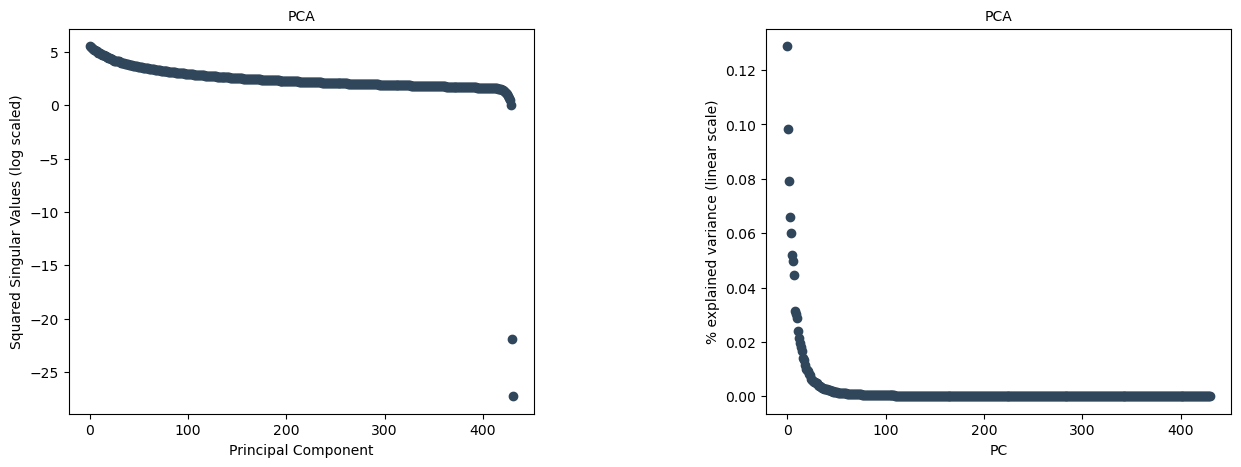

In [3]:
%matplotlib inline

# (1) centre the data and normalise (mean = 0, variance = 1)
data = StandardScaler().fit_transform(data)

# (2) make show data vectors are in rows
print('data shape:',data.shape)

# (3) take SVD of data
U, S_values, Vt = np.linalg.svd(data)
print('validating shape of V:', Vt.shape)

V = Vt.T

# (4) squared singular values - variance along each dimension
SSV = S_values**2
explained_variance = SSV/np.sum(SSV)
print("explained variance:", np.array_str(explained_variance[:10], precision=2, suppress_small=True))

# plot squared singular values
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
x_values = np.arange(data.shape[0])
ax.plot(np.log10(SSV),'o', color = colour1)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Principal Component')
plt.ylabel('Squared Singular Values (log scaled)')
plt.title('PCA', fontsize = 10)

# plot squared singular values - without taking the log
ax1 = fig.add_subplot(1,2,2)
ax1.plot(explained_variance,'o', color = colour1)
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('PC')
plt.ylabel('% explained variance (linear scale)')
plt.title('PCA', fontsize = 10)
plt.savefig('PCA.jpeg')
plt.subplots_adjust(wspace=0.5)
plt.show()

### Permutation test

In [4]:
def de_correlate_df(df):
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values
        
    return X_aux

In [5]:
df = pd.DataFrame(data)

In [6]:
pca = PCA()
pca.fit(df)
original_variance = pca.explained_variance_ratio_

In [7]:
original_variance[:4]

array([0.12879649, 0.09823917, 0.07912851, 0.06602243])

In [8]:
N_permutations = 1000
variance = np.zeros((N_permutations, len(df.columns)))

In [9]:
for i in range(N_permutations):
    X_aux = de_correlate_df(df)
    
    pca.fit(X_aux)
    variance[i, :] = pca.explained_variance_ratio_

In [10]:
p_val = np.sum(variance > original_variance, axis=0) / N_permutations
unique, counts = np.unique(p_val, return_counts=True)
dict(zip(unique, counts))

{0.0: 35, 1.0: 396}

## Plot data

In [11]:
proj_2pc = data @ V[:,0:2]

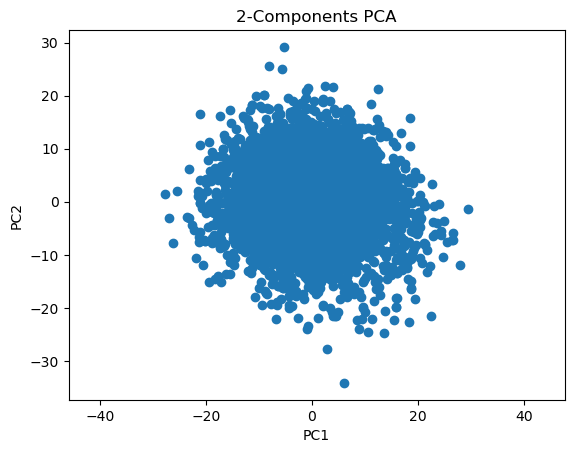

In [12]:
%matplotlib inline
plt.scatter(proj_2pc[:,0],proj_2pc[:,1])
plt.title('2-Components PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.show()

In [13]:
proj_3pc = data @ V[:,0:3]

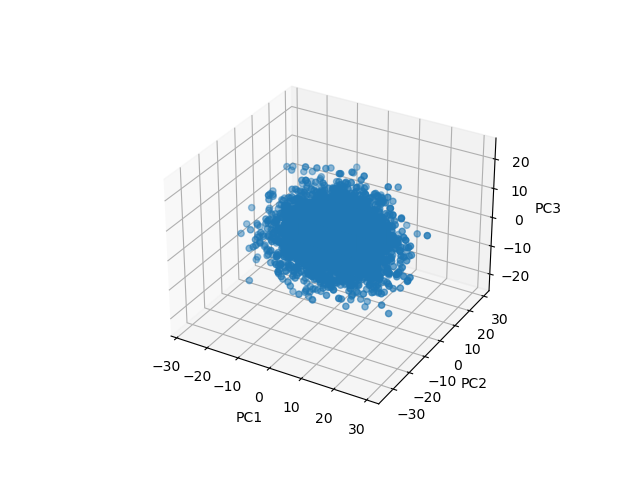

In [15]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(proj_3pc[:,0],proj_3pc[:,1],proj_3pc[:,2], cmap = 'plasma')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

### Clustering

In [16]:
# elbow
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)

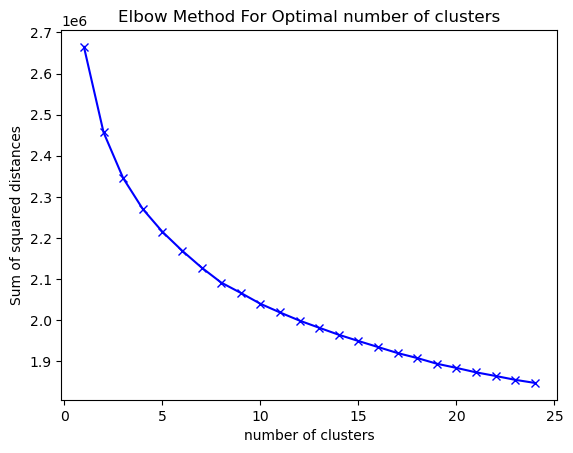

In [17]:
%matplotlib inline
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal number of clusters')
plt.show()

In [22]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
y_kmeans = kmeans.fit_predict(data)
centers = kmeans.cluster_centers_

NameError: name 'proj_3pc' is not defined

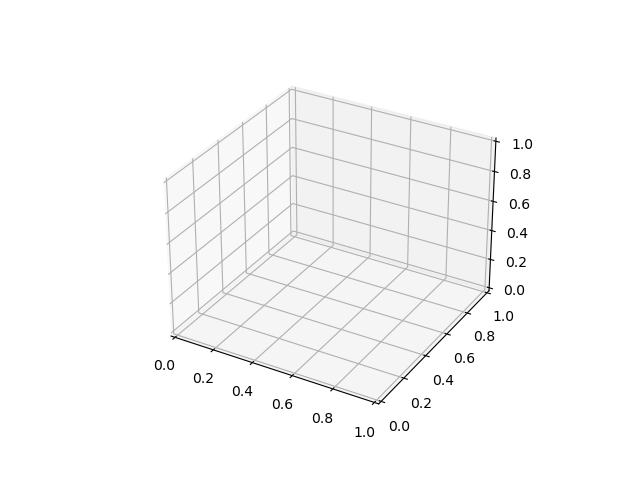

In [5]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(proj_3pc[:,0],proj_3pc[:,1],proj_3pc[:,2], c=y_kmeans, s=50, cmap=colours)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

if is_plot:
    for a in range(90):
            ax.view_init(elev=0, azim=a)
            plt.savefig('3d_figures/figure_{0}'.format(a)+'.png')
            for e in range(90):
                ax.view_init(elev=e, azim=a)
                plt.savefig('3d_figures/figure_{0}'.format(e+a)+'.png')
    
plt.show()

In [20]:
from PIL import Image
import glob

if is_plot:
# Create the frames
    frames = []
    imgs = sorted(glob.glob("3d_figures/*.png"), key=os.path.getmtime)
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save('png_to_gif.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=100, loop=0)

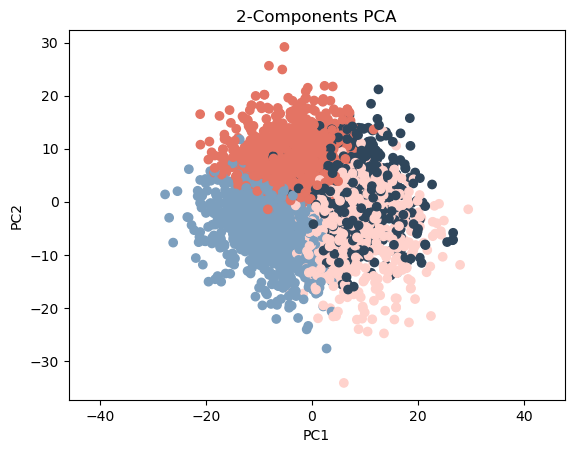

In [21]:
%matplotlib inline
plt.scatter(proj_2pc[:,0],proj_2pc[:,1], cmap = colours, c=y_kmeans)
plt.title('2-Components PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.savefig('2_components_pca.jpeg')
plt.show()

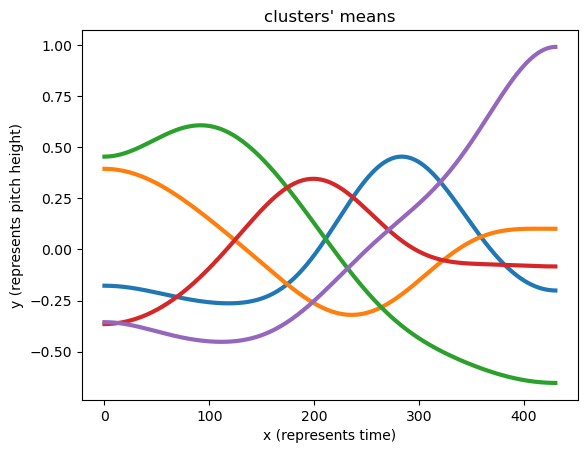

In [23]:
%matplotlib inline
# colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
plt.title("clusters' means")
plt.xlabel('x (represents time)')
plt.ylabel('y (represents pitch height)')
for i in range((centers.shape)[0]):
    # plt.plot(gaussian_filter1d(centers[i], sigma=50), color = colorarray[i], linewidth=3)
    plt.plot(gaussian_filter1d(centers[i], sigma=50), linewidth=3)
plt.savefig('clusters_means.jpeg')
plt.show()

Cluster: 1


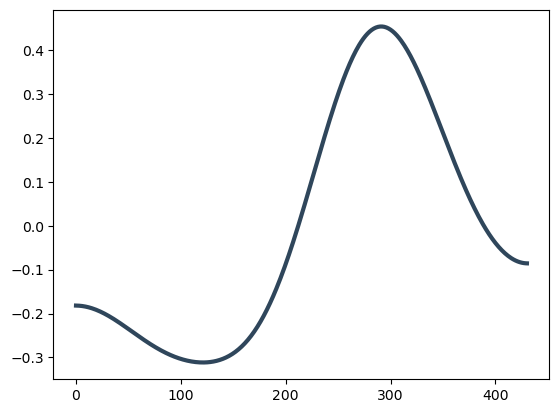

Cluster: 2


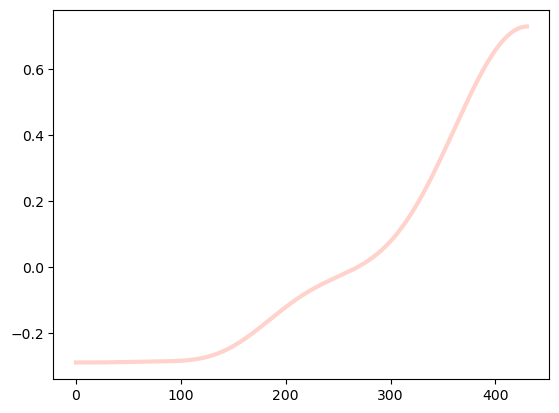

Cluster: 3


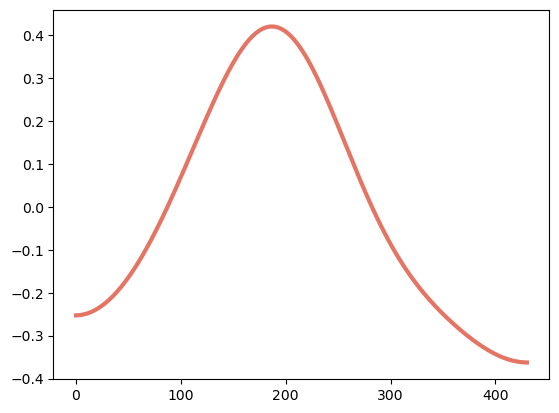

Cluster: 4


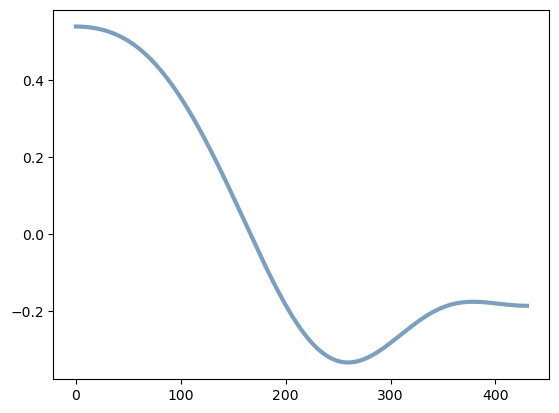

In [23]:
%matplotlib inline
# colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
for i in range((centers.shape)[0]):
    print('Cluster:', i+1)
#     plt.title("Cluster's means")
#     plt.xlabel('x (represents time)')
#     plt.ylabel('y (represents pitch height)')
    plt.plot(gaussian_filter1d(centers[i], sigma=50), color = colorarray[i], linewidth=3)
    plt.savefig('cluster{0}'.format(i+1)+'.jpeg')
    plt.show()

### check for effect of country

In [24]:
cluster_sizes = []
for cluster in range(n_clusters):
    print('cluster: ', cluster + 1)
    print(country[np.where(y_kmeans == cluster)])
    print('cluster size: ', len((country[np.where(y_kmeans == cluster)])))
    cluster_sizes.append(len((country[np.where(y_kmeans == cluster)])))

cluster:  1
['essen' 'essen' 'essen' ... 'essen' 'essen' 'essen']
cluster size:  1273
cluster:  2
['essen' 'essen' 'essen' ... 'essen' 'essen' 'essen']
cluster size:  1419
cluster:  3
['essen' 'essen' 'essen' ... 'essen' 'essen' 'essen']
cluster size:  1564
cluster:  4
['essen' 'essen' 'essen' ... 'essen' 'essen' 'essen']
cluster size:  1927


### Statistical analysis for cluster sizes

In [25]:
from scipy.stats import chisquare, chi2_contingency
from itertools import combinations
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests

df = pd.DataFrame(cluster_sizes)
chisquare(cluster_sizes)

Power_divergenceResult(statistic=152.76904415332365, pvalue=6.65881146429994e-33)

In [26]:
def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text


In [27]:
chi2, p = chisquare(df)
print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")

# post-hoc
all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
p_vals = []
chi2_vals = []
print("Significance results:")
for comb in all_combinations:
    new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
    chi2, p = chisquare(new_df)
    p_vals.append(float(p))
    chi2_vals.append(float(chi2))
# checking significance
# correction for multiple testing
reject_list, corrected_p_vals = multipletests(p_vals, method='bonferroni')[:2]
for chi2_val, p_val, corr_p_val, reject, comb in zip(chi2_vals, p_vals, corrected_p_vals, reject_list, all_combinations):
        print(f"{comb}: chi: {chi2_val:5f}; p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)}) reject: {reject}")

Chi2 result of the contingency table: [152.76904415], p-value: [6.65881146e-33]
Significance results:
(0, 1): chi: 7.918276; p_value: 0.004894; corrected: 0.029363 (**) reject: True
(0, 2): chi: 29.848784; p_value: 0.000000; corrected: 0.000000 (****) reject: True
(0, 3): chi: 133.661250; p_value: 0.000000; corrected: 0.000000 (****) reject: True
(1, 2): chi: 7.048274; p_value: 0.007934; corrected: 0.047605 (**) reject: True
(1, 3): chi: 77.126121; p_value: 0.000000; corrected: 0.000000 (****) reject: True
(2, 3): chi: 37.745345; p_value: 0.000000; corrected: 0.000000 (****) reject: True
